**利用普通克里金算法进行小样本预测** 

**本次试验的函数如下**
$$ z = x * \exp\{-x^2-y^2\} $$


**试验大体步骤**

（1）在给定范围$x\in[-2,2]$、$y\in[-2,3]$内进行拉丁超立方采样，形成数据集$D=(X,Z)$,其中X为数值对，即$X =(x,y)$
（2）克里金算法进行估计

In [1]:
import numpy as np
import mpl_toolkits.mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import preprocessing
import torch as t

### 1 函数$ z = x * \exp\{-x^2-y^2\} $曲面展示


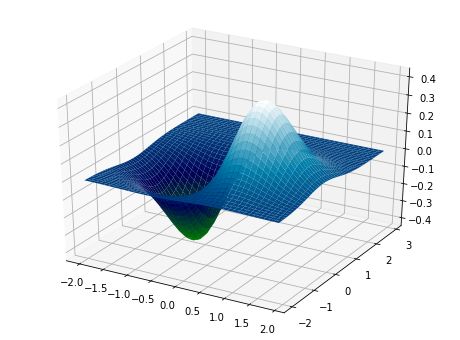

In [3]:
#func3d.py
x,y = np.mgrid[-2:2:0.1,-2:3:0.1]
z = x * np.exp(- x**2 - y**2)
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z,cmap=cm.ocean)
plt.show()

### 2 拉丁超立方采样

In [4]:
def lHSample(D,bound,N):
    '''
    @param
    D:维度数
    bound：每个维度的取值范围,shape为[D,2]
    N：待采样点个数     
    '''
    result = np.empty([N,D])
    tmp = np.empty([N])
    d  = 1 / N # 用来平分每个区间
    
    # 仅在【0，1】区间内进行采样，随后根据bound拉伸数据
    for i in range(D):
        for j in range(N):
            tmp[j] = np.random.uniform(low=j*d,high=(j+1)*d)
        np.random.shuffle(tmp)
        result[:,i] = tmp
#     print(result)
    lower_bounds = bound[:,0]
    upper_bounds = bound[:,1]
    result = result*(upper_bounds-lower_bounds)+lower_bounds
    return result

In [121]:
bounds = np.array([[-2,2],[-2,3]])
samples_X = lHSample(2,bounds,40) # [N,2]
samples_z = samples_X[:,0] * np.exp(- samples_X[:,0]**2 - samples_X[:,1]**2) #[N,]

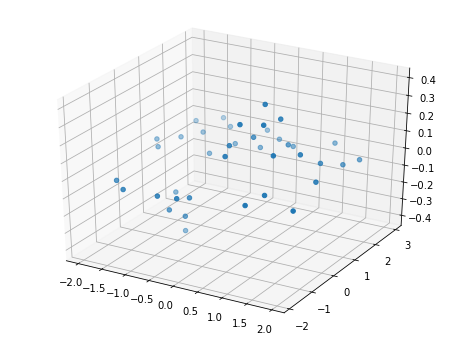

In [122]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(samples_X[:,0],samples_X[:,1],samples_z)

### 3 普通克里金估计 
**$x\in R^m,z\in R$**

**相关函数$R(x,x') = \prod\limits_{k=1}^{m} R_k(\theta_k,x_k,x_k')$**,其中$R_k(\theta_k,x_k,x_k')$如下


$$R_k(\theta_k,x_i,x_j) = \begin{cases}
1-\xi_k^2+30\xi_k^2 & 0\le\xi_k\le0.2\\
1.25(1-\xi_k)^3 & 0.2<\xi_k<1\\
0 & \xi_k\ge1
\end{cases}$$



参数$\theta$为待优化参数。通过最大化似然函数获得。具体参考《Kriging模型及代理优化算法研究进展》的1.4节。本次使用torch，基本随机梯度下降法优化$\theta$

In [123]:
class Kriging:
    def __init__(self,X,z,param_path=None):
        self.X = t.tensor(self.scaler(X),dtype=t.float)
        self.min_z = np.min(z)
        self.max_z = np.max(z)
        self.z = t.tensor(self.scaler(z.reshape(-1,1)),dtype=t.float) # [N,1]
        self.N = X.shape[0]
        self.D = X.shape[1]
        self.gama = (10**3+self.N)*2.2*10**(-16)
        
        self.theta = t.tensor(np.random.uniform(1,2,size = self.D),requires_grad=True,dtype=t.float)
#         print(self.theta)
        
    def scaler(self,x):
        min_max_scaler1 = preprocessing.MinMaxScaler()
        return min_max_scaler1.fit_transform(x).astype(np.float32)


        
    def R(self,x1,x2):
        # x1,x2:[D,]
        #计算Rk
        xi = self.theta*t.abs(x1 - x2) # [D,]
        Rk = t.zeros([xi.shape[0]])
        for i in range(len(xi)):
            if 0<=xi[i] and xi[i]<=0.2:
                Rk[i] = 1 - 15*xi[i]**2 + 30*xi[i]**3
            elif 0.2<xi[i] and xi[i]<1 :
                Rk[i] = 1.25*(1-xi[i])**3
            else:
                Rk[i] = 0
        res = 1
        for i in Rk:
            res *= i
        return res
    
    def liklyhood(self):
        R_matrix = t.ones([self.N,self.N])
        for i in range(self.N):
            for j in range(self.N):
                R_matrix[i,j] = self.R(self.X[i],self.X[j])
#         print(R_matrix.requires_grad)
        F = t.ones([self.N,1])
        beta = t.inverse(t.transpose(F,0,1)@t.inverse(R_matrix)@F)@t.transpose(F,0,1)@t.inverse(R_matrix)@self.z
        sigma = 1 / self.N * t.transpose(self.z-beta*F,0,1)@t.inverse(R_matrix)@(self.z-beta*F)
        log_liklyhood = self.N / 2 *t.log(sigma) + 0.5 * t.log(t.det(R_matrix))
        return log_liklyhood
        
    def train(self,epochs=100):
        optim = t.optim.SGD([self.theta],lr=0.005)
        for epoch in range(epochs):
            optim.zero_grad()
            log_liklyhood = self.liklyhood()
            log_liklyhood.backward()
            optim.step()
            if epoch % 10 == 0:
                print("epoch {}, log_liklyhood {}".format(epoch,log_liklyhood.item()))
    
#     def save_parm(self):
        
    def predict(self,newX):
        '''
        newX:[N_new,D]
        '''
        N_new = newX.shape[0]
        R_matrix = t.ones([self.N,self.N])
        gama_matrix = np.ones([self.N])
        for i in range(self.N):
            gama_matrix[i] = self.gama
        gama_matrix = t.tensor(np.diag(gama_matrix),dtype=t.float)
        for i in range(self.N):
            for j in range(self.N):
                R_matrix[i,j] = self.R(self.X[i],self.X[j])
        R_matrix += gama_matrix
        F = t.ones([self.N,1])
        beta = t.inverse(t.transpose(F,0,1)@t.inverse(R_matrix)@F)@t.transpose(F,0,1)@t.inverse(R_matrix)@self.z
        r = t.ones([self.N,1])
        res = t.ones([N_new])
        for i in range(N_new):
            for j in range(self.N):
                r[j] = self.R(self.X[j],newX[i])
            tmp = beta + t.transpose(r,0,1)@t.inverse(R_matrix)@(self.z-beta*F)
            tmp = tmp.item()*(self.max_z-self.min_z)+self.min_z
            res[i] = tmp
        return res.numpy()
    

In [124]:
k = Kriging(samples_X,samples_z)
k.train()

epoch 0, log_liklyhood -93.22113800048828
epoch 10, log_liklyhood -97.23612976074219
epoch 20, log_liklyhood -100.1034927368164
epoch 30, log_liklyhood -101.2384262084961
epoch 40, log_liklyhood -101.62840270996094
epoch 50, log_liklyhood -101.70043182373047
epoch 60, log_liklyhood -101.70663452148438
epoch 70, log_liklyhood -101.70698547363281
epoch 80, log_liklyhood -101.70704650878906
epoch 90, log_liklyhood -101.70706939697266


In [129]:
newX = t.tensor(np.random.uniform(size = [40,2]),dtype = t.float)
origin_newX = (newX*t.tensor([4.0,5.0])+t.tensor([-2.0,-2.0])).numpy()

In [130]:
real_z = origin_newX[:,0] * np.exp(- origin_newX[:,0]**2 - origin_newX[:,1]**2)

In [131]:
pred_z = k.predict(newX)

### 4 估计结果评估

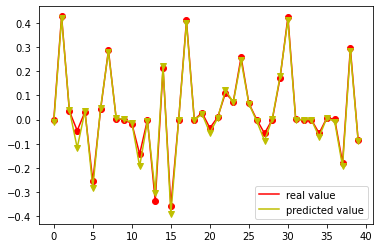

In [132]:
plt.plot(real_z,color='r',label='real value')
plt.plot(real_z,'o',color='r')
plt.plot(pred_z,color='y',label='predicted value')
plt.plot(pred_z,'v',color='y')
plt.legend()